In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

from gofish import imagecube  # for the CLEAN profile
sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err

from scipy.integrate import simpson
from scipy.signal import find_peaks

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [2]:
##### MODIFY HERE #####

target = 'AA_Tau'
target_label = 'AA Tau'

robust = -0.5

lim = 2.2    # arcsec, maximum radius of the profile to be plotted
maj_ticks = 0.5          # arcsec, spacing of the major ticks in figures
min_ticks = maj_ticks/5  # arcsec, spacing of the minor ticks in figures
FOV_gofish = 5     # Clip the image cube down to a specific field-of-view spanning a range ``FOV``, where ``FOV`` is in [arcsec]
dr_gofish = None     #  Width of the annuli to split the integrated region into in [arcsec]. Default is quater of the beam major axis


# load data
data_fits = f'../frank_fit/CLEAN/robust{robust}/{target}_data_robust{robust}.fits'
dhdu = fits.open(data_fits)
dimg, hd = np.squeeze(dhdu[0].data), dhdu[0].header
freq = hd['CRVAL3']

bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

distance_pc = disk.disk[target]['distance']

In [5]:
#############################
### Plot the radial profile
############################

# Obtain the CLEAN profile using the imagecube function from gofish
cube = imagecube(data_fits, FOV=FOV_gofish)

r_clean, I_clean, dI_clean = cube.radial_profile(x0=disk.disk[target]['dx'], y0=disk.disk[target]['dy'], inc=disk.disk[target]['incl'], PA=disk.disk[target]['PA'], dr=dr_gofish)
def _calculate_flux_jy_sr(data,bmin,bmaj):
    omega = np.radians(bmin / 3600.)
    omega *= np.radians(bmaj / 3600.)
    beam_area = np.pi * omega / 4. / np.log(2.)
    return data / beam_area

I_clean_b  = _calculate_flux_jy_sr( I_clean,cube.bmin,cube.bmaj)
dI_clean_b = _calculate_flux_jy_sr(dI_clean,cube.bmin,cube.bmaj)

r_clean_au =  r_clean * distance_pc
Tb_clean, dTb_clean = Jysr_to_Tb_err(Jybeam_to_Jysr(I_clean, bmin, bmaj), Jybeam_to_Jysr(dI_clean, bmin, bmaj), freq)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


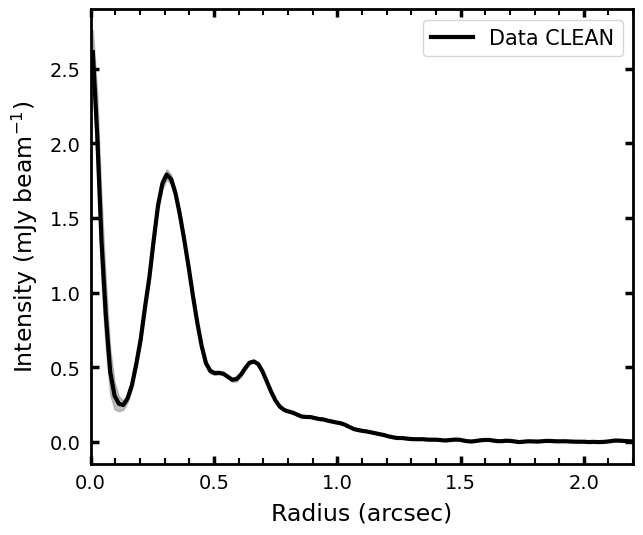

In [7]:
fig = plt.figure(figsize=(7, 5.9))
ax = fig.add_subplot(111)

ax.fill_between(r_clean, (I_clean-dI_clean)*1e3, (I_clean+dI_clean)*1e3, color='gray', alpha=0.5)
ax.plot(r_clean, I_clean*1e3, 'k', lw=3, label='Data CLEAN')

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Intensity (mJy beam$^{-1}$)', fontsize = 17, labelpad=7)
ax.legend(fontsize=15)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

(10000000.0, 80000000000.0)

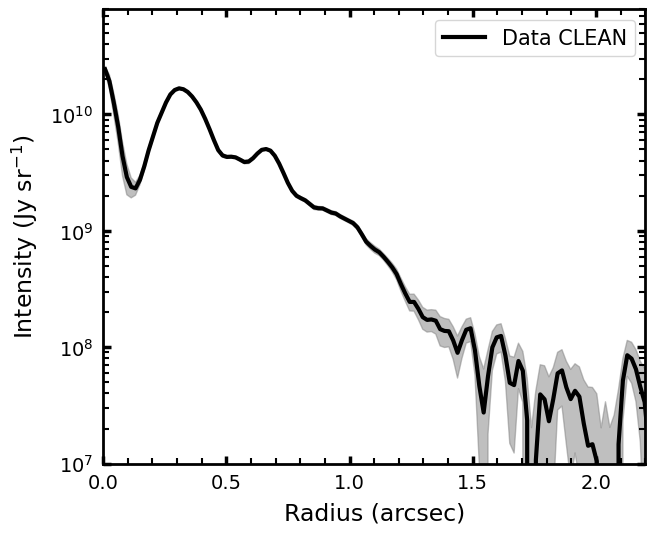

In [9]:
fig = plt.figure(figsize=(7, 5.9))
ax = fig.add_subplot(111)

ax.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)
ax.legend(fontsize=15)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

ax.set_yscale('log')
ymin=1e7
ymax=8e10
ax.set_ylim([ymin, ymax]) 

In [11]:
# CLEAN profile
np.savetxt(f'{target}_CLEAN_profile_robust{robust}.txt',
           np.column_stack([r_clean, r_clean_au, I_clean*1e3, dI_clean*1e3, Tb_clean, dTb_clean, Jybeam_to_Jysr(I_clean, bmin, bmaj), Jybeam_to_Jysr(dI_clean, bmin, bmaj)]),
           fmt='%10.6e', delimiter='\t',
           header=f'Intensity radial profile from the CLEAN image of {target} with robust={robust}\nThe brightness temperature is computed using the full Planck law\nColumns:\tR(arcsec)\tR(au)\tIntensity(mJy/beam)\td_Intensity(mJy/beam)\tBrightness_temperature(K)\td_Brightness_temperature(K)\tIntensity(Jy/sr)\td_Intensity(Jy/sr)')

In [13]:
integrand  = 2*np.pi*r_clean*arcsec*Jybeam_to_Jysr(I_clean, bmin, bmaj)
cumulative = np.cumsum(integrand)
norm_numerical_cumulative = np.cumsum(integrand)/np.amax(np.cumsum(integrand))

tot_flux =  simpson(integrand, r_clean*arcsec) * np.cos(disk.disk[target]['incl']*deg) *1e3
print(f'Total flux from CLEAN profile = {tot_flux:.2f} mJy')

Total flux from CLEAN profile = 193.24 mJy
